<a href="https://colab.research.google.com/github/kruttikajain/Targetted-Abusive_Language_Online/blob/master/prediciton1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abusive Language Online 

Predition1: predict OFF/NOT

* Upload it each time: Dataset: [data](http://demo.clab.cs.cmu.edu/ethical_nlp2019/homeworks/hw3/hw3.html)


1.   train.tsv
2.   dev.tsv
3.   test.tsv

* Need manually add log.txt
* Mount drive to load GloVe embeddings




# Import useful lib

In [1]:
import os
import sys
from logging import handlers
from pathlib import Path
import logging
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import random 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, CuDNNLSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline 
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data proprecessing

## mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pwd

/content


In [4]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = '' 
# replace with your Github username 
GIT_USERNAME = "kruttikajain" 
# definitely replace with your
GIT_TOKEN = "5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "Targetted-Abusive_Language_Online" 

# PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

'''
only this line should be modify
'''
PROJECT_PATH = './gdrive/My Drive/Colab Notebooks/246Project'

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  ./gdrive/My Drive/Colab Notebooks/246Project
mkdir: cannot create directory ‘./gdrive/My Drive/Colab Notebooks/246Project’: File exists
GIT_PATH:  https://5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c@github.com/kruttikajain/Targetted-Abusive_Language_Online.git


## Prepare logging file

In [5]:
def init_logger(log_file):
    if not os.path.exists(log_file):
        os.makedirs(os.path.dirname(log_file))

    log = logging.getLogger('')
    log.setLevel(logging.INFO)
    output_format = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    std_out_handler = logging.StreamHandler(sys.stdout)
    std_out_handler.setFormatter(output_format)
    logging.getLogger().addHandler(std_out_handler)
    file_handler = logging.handlers.RotatingFileHandler(log_file, maxBytes=(1048576*5), backupCount=7)
    file_handler.setFormatter(output_format)
    logging.getLogger().addHandler(file_handler)

init_logger(PROJECT_PATH + '/log.txt')
logging.info('=============start2=================')
logging.info('logging file prepared...')

2020-05-07 06:33:18 INFO     =============start2=================
2020-05-07 06:33:18 INFO     logging file prepared...


## load data

In [6]:
def load_data():
    logging.info('loading the dataset...')
    train_df = pd.read_csv(PROJECT_PATH + '/project_data/train.tsv', sep="\t")
    val_df = pd.read_csv(PROJECT_PATH + '/project_data/dev.tsv', sep="\t")
    test_df = pd.read_csv(PROJECT_PATH + '/project_data/test.tsv', sep="\t")
    
    # shape of df, column names
    logging.info('Train shape : ' + str(train_df.shape)) # 'text', 'label', 'category'
    logging.info('Val shape: ' + str(val_df.shape))
    logging.info('Test shape: ' + str(test_df.shape))
    
    logging.info('train_df.columns: ' + train_df.columns)
    logging.info('val_df.columns: ' + val_df.columns)
    logging.info('test_df.columns: ' + test_df.columns)

    return train_df, val_df, test_df

train_df, val_df, test_df = load_data()

2020-05-07 06:33:18 INFO     loading the dataset...
2020-05-07 06:33:19 INFO     Train shape : (10592, 3)
2020-05-07 06:33:19 INFO     Val shape: (1324, 3)
2020-05-07 06:33:19 INFO     Test shape: (1324, 1)
2020-05-07 06:33:19 INFO     NumExpr defaulting to 2 threads.
2020-05-07 06:33:19 INFO     Index(['train_df.columns: text', 'train_df.columns: label',
       'train_df.columns: category'],
      dtype='object')
2020-05-07 06:33:19 INFO     Index(['val_df.columns: text', 'val_df.columns: label',
       'val_df.columns: category'],
      dtype='object')
2020-05-07 06:33:19 INFO     Index(['test_df.columns: text'], dtype='object')


In [7]:
train_df.head()

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood nex...,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Libera...,OFF,TIN
3,@USER @USER And not all idiots grandstands lik...,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN


**Attributes in data:**


***Trainning data:***  (10592, 3) \\

* **text:** \\
tweet content

* **label:** \\
1.   (NOT) Not Offensive - This post does not contain offense or profanity
2.   (OFF) Offensive - This post contains offensive language or a targeted (veiled or direct) offense

* **category:** (if label is 'OFF') \\
1.   (TIN) Targeted Insult and Threats - A post containing an insult or threat to an individual, a group, or others
2.   (UNT) Untargeted - A post containing non-targeted profanity and swearing.

***Validation data:***  (1324, 3) \\

***Testing data***:  'text' (1324, 1) \\
* **text**

## Data cleaning

In [0]:
def data_cleaning(train_df, val_df, test_df):
    # shuffle data
    train_df = train_df.sample(frac=1, random_state=2020).reset_index(drop=True)
    
    # lo lowercae
    train_df['text'] = train_df['text'].str.lower()
    val_df['text'] = val_df['text'].str.lower()
    test_df['text'] = test_df['text'].str.lower()

    # delete "noise words"
    noise = ["url","user","@","&amp;","#","-",'.',"!","?","rt","dm","retweet","rt","dm"]
    for WORD in noise:
        train_df['text'] = train_df['text'].str.replace(WORD, '')
        val_df['text'] = val_df['text'].str.replace(WORD, '')
        test_df['text'] = test_df['text'].str.replace(WORD, '')

    # change label to 0/a
    train_df['label'] = train_df['label'].map({'OFF': 1, 'NOT': 0})
    val_df['label'] = val_df['label'].map({'OFF': 1, 'NOT': 0})

    # one-hot encoding of category
    train_df = pd.concat([train_df,pd.get_dummies(train_df['category'], prefix='category')],axis=1)
    train_df.drop(['category'],axis=1, inplace=True)
    
    val_df = pd.concat([val_df,pd.get_dummies(val_df['category'], prefix='category')],axis=1)
    val_df.drop(['category'],axis=1, inplace=True)
    return train_df, val_df, test_df

train_df, val_df, test_df = data_cleaning(train_df, val_df, test_df)


In [9]:
val_df.head(10)

,text,label,category_TIN,category_UNT
0,she should ask a few native americans what th...,1,0,1
1,go home you’re drunk maga trump2020 👊🇺🇸👊,1,1,0
2,amazon is investigating chinese employees who ...,0,0,0
3,"someone should'vetaken"" this piece of shit to...",1,0,1
4,obama wanted liberals illegals to move into...,0,0,0
5,liberals are all kookoo,1,1,0
6,oh noes tough shit,1,0,1
7,was literally just talking about this lol all...,1,1,0
8,buy more icecream,0,0,0
9,canada doesn’t need another cuck we already h...,1,1,0


Check the content of abusive text

In [10]:
abusive_df = train_df.loc[train_df['label'] == 1]
# pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
abusive_df['text'].head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


0      didn't this trashy thing sleep her way to the top with married men                                                                 
1       gfy the nfl should get no protection from the policeand no suppo from our militarythe league will slowly die on this road of shame
10     👀 sitting here thinking he has a killer porn stache                                                                                
13    all trump's and pense 2020 merch is being made is china and not the usa    maga    votethemout2018  trumpsarmy                      
16     gun control now enough is enough                                                                                                   
Name: text, dtype: object

## Data distribution and visualization 

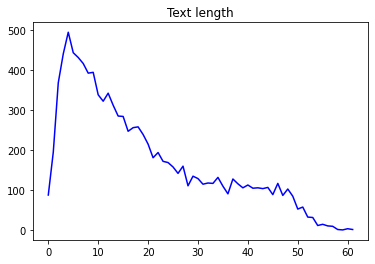

2020-05-07 06:33:20 INFO     number of label = 1 : 3520
2020-05-07 06:33:20 INFO     number of category_TIN = 1: 3089
2020-05-07 06:33:20 INFO     number of category_UNT = 1: 431


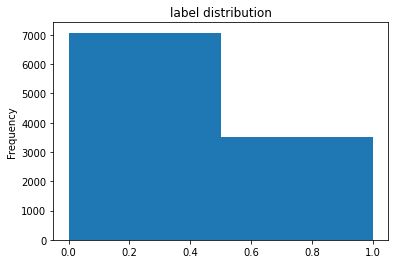

In [11]:
# count how many letters in a sentence
def label_distribution(train_df):
    #  length of text
    count = train_df['text'].str.split().apply(len).value_counts()
    count.sort_index(inplace=True)
    count.index = count.index.astype(str) + ' words:'
    # logging.info(count[0:5])
    # logging.info(count[-5:])
    plt.plot(range(len(count)), count, color='blue')
    plt.title("Text length")
    plt.show()
    # label distribution
    logging.info('number of label = 1 : ' + str((train_df['label'] != 0).sum()))
    logging.info('number of category_TIN = 1: ' + str((train_df['category_TIN'] != 0).sum()))
    logging.info('number of category_UNT = 1: ' + str((train_df['category_UNT'] != 0).sum()))

    # plot histogram
    train_df['label'].plot.hist(bins=2, title='label distribution')
    plt.show()

label_distribution(train_df)


**Property of dataset**

*   **Length of text:** [2, 60]

*   **label:** 
1.   label = 0: 7072
2.   label = 1: 3520

* Among label = 1: \\
1.   category_TIN = 1: 3089
2.   category_UNT = 1: 431



Word cloud

In [12]:
# word cloud
normal_df = train_df.loc[train_df.label == 0]
abusive_df = train_df.loc[train_df.label == 1]

normal_text_array = np.array(normal_df['text'])
abusive_text_array = np.array(abusive_df['text'])

normal_text = ''.join(normal_text_array)
abusive_text = ''.join(abusive_text_array)

logging.info("convert to text finished")

2020-05-07 06:33:20 INFO     convert to text finished


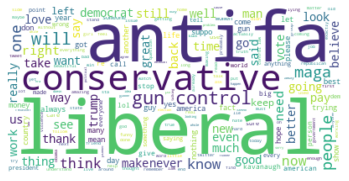

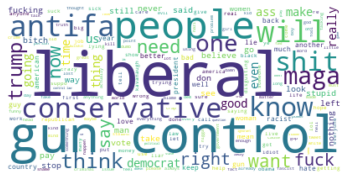

In [13]:
# normal
wordcloud = WordCloud(background_color="white").generate(normal_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# abusive
wordcloud = WordCloud(background_color="white").generate(abusive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Delete some common words

In [0]:
normal_text = normal_text.replace('liberal','',1000).replace('people','',1000).replace('will','',1000)
abusive_text = abusive_text.replace('liberal','',1000).replace('people','',1000).replace('will','',1000)

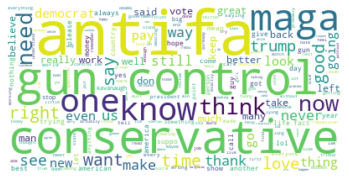

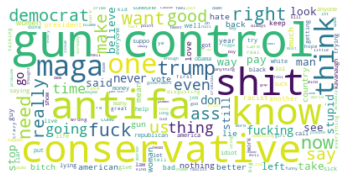

In [15]:
# normal
wordcloud = WordCloud(background_color="white").generate(normal_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# abusive
wordcloud = WordCloud(background_color="white").generate(abusive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Split data to X and y

Split data to X and y

In [16]:
def split_train_val(train_df, val_df, test_df):
    logging.info('splitting X and y ...')
    train_X = train_df["text"].fillna("_na_").values
    val_X = val_df["text"].fillna("_na_").values
    test_X = test_df["text"].fillna("_na_").values

    train_y = train_df['label'].values
    val_y = val_df['label'].values

    logging.info('finished splitting X and y')
    return train_X, val_X, test_X, train_y, val_y

train_X, val_X, test_X, train_y, val_y = split_train_val(train_df, val_df, test_df)

2020-05-07 06:33:24 INFO     splitting X and y ...
2020-05-07 06:33:24 INFO     finished splitting X and y


In [17]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(10592,) (10592,)
(1324,) (1324,)


Tokenize and padding each sentence, split datafram to attributes and labels

In [18]:
# each word embedding to 300 dimension
embed_size = 300
# count of vocabulary words
max_features = 50000
# length of each sentences
max_len = 70

def token_sentence(train_X, val_X, test_X ):
    logging.info('tokenizing sentence...')
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    logging.info('padding sentence...')
    train_X = pad_sequences(train_X, maxlen=max_len)
    val_X = pad_sequences(val_X, maxlen=max_len)
    test_X = pad_sequences(test_X, maxlen=max_len)

    logging.info('all finished...')
    return train_X, val_X, test_X, tokenizer

train_X, val_X, test_X, tokenizer = token_sentence(train_X, val_X, test_X)


2020-05-07 06:33:24 INFO     tokenizing sentence...
2020-05-07 06:33:24 INFO     padding sentence...
2020-05-07 06:33:24 INFO     all finished...


In [19]:
train_X.shape

(10592, 70)

# Train model

## Model1: base line

In [0]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score

### Decision tree

In [0]:
def dt_model(train_X, train_y, val_X, cal_y):
    dt_clf = tree.DecisionTreeClassifier()
    dt_clf = dt_clf.fit(train_X, train_y)
    pred_val_y = dt_clf.predict(val_X).reshape(-1,1)
    dt_acc = accuracy_score(pred_val_y, val_y)
    dt_f1_score = f1_score(pred_val_y, val_y)
    return dt_acc, dt_f1_score

In [22]:
dt_acc, dt_f1_score = dt_model(train_X, train_y, val_X, val_y)
print('dt_acc: ', dt_acc, ', dt_f1_score: ',  dt_f1_score)

dt_acc:  0.5664652567975831 , dt_f1_score:  0.3650442477876106


### LogisticRegression

In [0]:
def lr_model(train_X, train_y, val_X, cal_y):
    lr_clf = LogisticRegression(random_state=0, max_iter=4000).fit(train_X, train_y)
    pred_val_y = lr_clf.predict(val_X).reshape(-1,1)
    lr_acc = accuracy_score(pred_val_y, val_y)
    lr_f1_score = f1_score(pred_val_y, val_y)
    return lr_acc, lr_f1_score

In [24]:
lr_acc, lr_f1_score = lr_model(train_X, train_y, val_X, val_y)
print('lr_acc: ', lr_acc, ', lr_f1_score: ',  lr_f1_score)

lr_acc:  0.6661631419939577 , lr_f1_score:  0.0045045045045045045


### GaussianNB

In [0]:
def gNB_model(train_X, train_y, val_X, cal_y):
    gNB_clf = GaussianNB()
    gNB_clf = gNB_clf.fit(train_X, train_y)
    pred_val_y = gNB_clf.predict(val_X).reshape(-1,1)
    gNB_acc = accuracy_score(pred_val_y, val_y)
    gNB_f1_score = f1_score(pred_val_y, val_y)
    return gNB_acc, gNB_f1_score

In [26]:
gNB_acc, gNB_f1_score = gNB_model(train_X, train_y, val_X, val_y)
print('gNB_acc: ', gNB_acc, ', gNB_f1_score: ',  gNB_f1_score)

gNB_acc:  0.3323262839879154 , gNB_f1_score:  0.49829738933030654


## Model2 : LSTM + Without Pretrained Embeddings:

In [27]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()

# Add an Embedding layer expecting input vocab of size 50000, and
# output embedding dimension of size 300.
model.add(layers.Embedding(input_dim=50000, output_dim=300))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))
model.add(layers.Dense(10,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,220,949
Trainable params: 15,220,949
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)
history = model.fit(train_X, 
                    train_y, 
                    batch_size=512, 
                    epochs=14, 
                    validation_data=(val_X, val_y),
                    callbacks=callbacks
                    )

Epoch 1/14
21/21 [==============================] - 25s 1s/step - loss: 0.6458 - accuracy: 0.6602 - val_loss: 0.6262 - val_accuracy: 0.6677
Epoch 2/14
21/21 [==============================] - 24s 1s/step - loss: 0.5783 - accuracy: 0.6897 - val_loss: 0.5715 - val_accuracy: 0.7130
Epoch 3/14
21/21 [==============================] - 24s 1s/step - loss: 0.4178 - accuracy: 0.8288 - val_loss: 0.5573 - val_accuracy: 0.7251
Epoch 4/14
21/21 [==============================] - 24s 1s/step - loss: 0.2484 - accuracy: 0.9078 - val_loss: 0.7567 - val_accuracy: 0.7137
Epoch 5/14
21/21 [==============================] - 24s 1s/step - loss: 0.1558 - accuracy: 0.9477 - val_loss: 0.8683 - val_accuracy: 0.7047


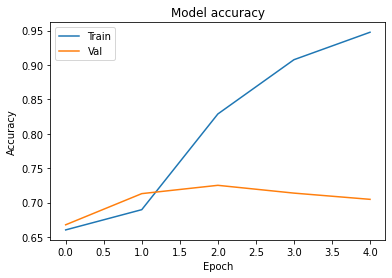

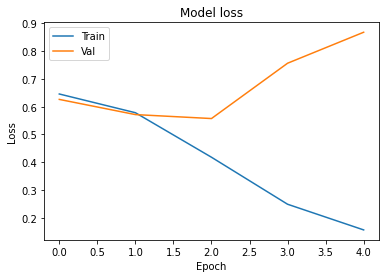

In [29]:
# plot history
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [30]:
# validation the model(f1-score)
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
print(pred_noemb_val_y)
threshes=[]
f1_scores=[]
accuracy_scores=[]
for thresh in np.arange(0.1, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    threshes.append(thresh)
    logging.info("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    f1_scores.append(metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int)))
    print("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    accuracy_scores.append(metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int)))


2/2 [==============================] - 0s 115ms/step
[[0.00696462]
 [0.1630331 ]
 [0.02782574]
 ...
 [0.07235903]
 [0.9332065 ]
 [0.22173621]]
2020-05-07 06:35:43 INFO     F1 score at threshold 0.1 is 0.5729927007299269
Accuracy at threshold 0.1 is 0.6465256797583081
2020-05-07 06:35:43 INFO     F1 score at threshold 0.11 is 0.5714285714285714
Accuracy at threshold 0.11 is 0.6510574018126888
2020-05-07 06:35:43 INFO     F1 score at threshold 0.12 is 0.5660731021555764
Accuracy at threshold 0.12 is 0.6503021148036254
2020-05-07 06:35:43 INFO     F1 score at threshold 0.13 is 0.571157495256167
Accuracy at threshold 0.13 is 0.6586102719033232
2020-05-07 06:35:43 INFO     F1 score at threshold 0.14 is 0.5670498084291188
Accuracy at threshold 0.14 is 0.6586102719033232
2020-05-07 06:35:43 INFO     F1 score at threshold 0.15 is 0.5640038498556305
Accuracy at threshold 0.15 is 0.6578549848942599
2020-05-07 06:35:43 INFO     F1 score at threshold 0.16 is 0.5622568093385214
Accuracy at threshol

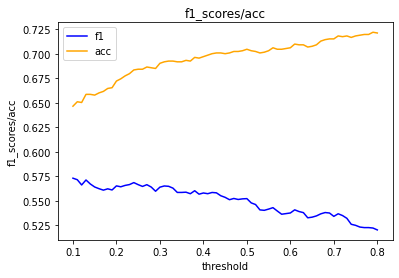

In [31]:
# plot two measures
plt.plot(threshes, f1_scores, color='blue', label='f1')
plt.plot(threshes, accuracy_scores, color='orange', label='acc')
plt.title('f1_scores/acc')
plt.ylabel('f1_scores/acc')
plt.xlabel('threshold')
plt.legend()
plt.show()

## Model3: LSTM + Pretrained embeddings

Embeddings:
glove.840B.300d - https://nlp.stanford.edu/projects/glove/
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106

It will take several minutes to load this 5G file. Be patient.. 





In [32]:
import io
embeddings_index = {}
logging.info("Loading Glove Model")
with io.open(PROJECT_PATH +'/glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
logging.info("Loading Glove Model Done")

2020-05-07 06:35:43 INFO     Loading Glove Model
2020-05-07 06:39:30 INFO     Loading Glove Model Done


In [33]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

print(all_embs.shape, emb_mean, emb_std, embed_size )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(2195893, 300) -0.005839112 0.48782477 300


In [34]:
word_index = tokenizer.word_index
len(word_index)

19626

In [35]:
nb_words = min(max_features, 1 + len(word_index))
nb_words

19627

In [36]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
embedding_matrix.shape

(19627, 300)

In [37]:
for word, i in word_index.items(): 
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(19627, 300)


In [38]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.initializers import Constant

model = tf.keras.Sequential()
model.add(layers.Embedding(nb_words,
                            300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
model.add(layers.LSTM(128))
model.add(layers.Dense(10,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           5888100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 6,109,049
Trainable params: 220,949
Non-trainable params: 5,888,100
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)

history = model.fit(train_X, 
                    train_y, 
                    batch_size=512, 
                    epochs=15, 
                    validation_data=(val_X, val_y),
                    callbacks=callbacks
                    )

Epoch 1/15
21/21 [==============================] - 18s 863ms/step - loss: 0.6472 - accuracy: 0.6172 - val_loss: 0.5954 - val_accuracy: 0.6888
Epoch 2/15
21/21 [==============================] - 17s 829ms/step - loss: 0.5565 - accuracy: 0.7266 - val_loss: 0.5187 - val_accuracy: 0.7583
Epoch 3/15
21/21 [==============================] - 17s 817ms/step - loss: 0.5111 - accuracy: 0.7641 - val_loss: 0.5247 - val_accuracy: 0.7523
Epoch 4/15
21/21 [==============================] - 17s 817ms/step - loss: 0.4944 - accuracy: 0.7763 - val_loss: 0.4861 - val_accuracy: 0.7742
Epoch 5/15
21/21 [==============================] - 17s 813ms/step - loss: 0.4735 - accuracy: 0.7892 - val_loss: 0.4809 - val_accuracy: 0.7734
Epoch 6/15
21/21 [==============================] - 17s 816ms/step - loss: 0.4538 - accuracy: 0.7965 - val_loss: 0.4766 - val_accuracy: 0.7779
Epoch 7/15
21/21 [==============================] - 17s 818ms/step - loss: 0.4443 - accuracy: 0.8017 - val_loss: 0.4849 - val_accuracy: 0.7696

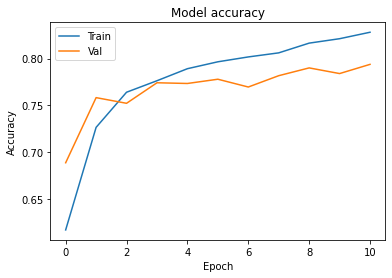

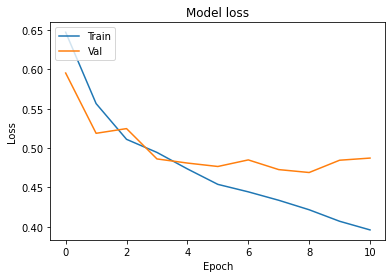

In [41]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [42]:
# validation the model(f1-score)
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
print(pred_noemb_val_y)
threshes=[]
f1_scores=[]
accuracy_scores=[]
for thresh in np.arange(0.1, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    threshes.append(thresh)
    logging.info("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    f1_scores.append(metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int)))
    print("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    accuracy_scores.append(metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int)))

2/2 [==============================] - 0s 117ms/step
[[0.07273242]
 [0.38957193]
 [0.0080224 ]
 ...
 [0.24812624]
 [0.13163361]
 [0.13128898]]
2020-05-07 06:43:03 INFO     F1 score at threshold 0.1 is 0.6231884057971014
Accuracy at threshold 0.1 is 0.6465256797583081
2020-05-07 06:43:03 INFO     F1 score at threshold 0.11 is 0.6301824212271974
Accuracy at threshold 0.11 is 0.6631419939577039
2020-05-07 06:43:03 INFO     F1 score at threshold 0.12 is 0.6302521008403361
Accuracy at threshold 0.12 is 0.6676737160120846
2020-05-07 06:43:03 INFO     F1 score at threshold 0.13 is 0.63840830449827
Accuracy at threshold 0.13 is 0.6842900302114804
2020-05-07 06:43:03 INFO     F1 score at threshold 0.14 is 0.6418439716312057
Accuracy at threshold 0.14 is 0.6948640483383686
2020-05-07 06:43:03 INFO     F1 score at threshold 0.15 is 0.6400725294650952
Accuracy at threshold 0.15 is 0.7001510574018127
2020-05-07 06:43:03 INFO     F1 score at threshold 0.16 is 0.6457564575645756
Accuracy at threshold

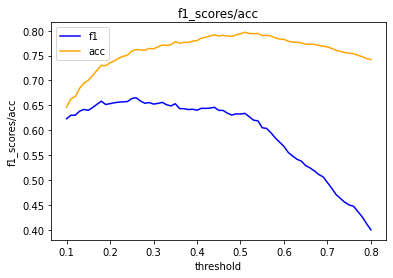

In [43]:
# plot two measures
plt.plot(threshes, f1_scores, color='blue', label='f1')
plt.plot(threshes, accuracy_scores, color='orange', label='acc')
plt.title('f1_scores/acc')
plt.ylabel('f1_scores/acc')
plt.xlabel('threshold')
plt.legend()
plt.show()

## Model4: CNN

In [44]:
logging.info('=========done===========')

2020-05-07 06:43:04 INFO     =========done===========


# Prediction 2
